<a href="https://colab.research.google.com/github/arshpreetsingh134/NLP-Twitter-Sentiment-Analysis/blob/master/Twitter_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [141]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer

### Here, we are using the **Sentiment140** dataset consisting of 1.6 million tweets that have been tagged as either positive or negative.

In [98]:
# Make data directory if it doesn't exist
# Here, we are using the Sentiment140 dataset consisting of 1.6 million tweets that have been tagged as either positive or negative.

!mkdir -p data
!wget -nc https://nyc3.digitaloceanspaces.com/ml-files-distro/v1/sentiment-analysis-is-bad/data/training.1600000.processed.noemoticon.csv.zip -P data
!unzip -n -d data data/training.1600000.processed.noemoticon.csv.zip

File ‘data/training.1600000.processed.noemoticon.csv.zip’ already there; not retrieving.

Archive:  data/training.1600000.processed.noemoticon.csv.zip


In [99]:
df = pd.read_csv("data/training.1600000.processed.noemoticon.csv",
                names=['label', 'id', 'date', 'query', 'user', 'tweet'],
                encoding='latin-1')
df.head()

,label,id,date,query,user,tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


### We currently have **800,000 positive tweets** and **800,000 negative tweets** in our dataset.

In [100]:
df.label.value_counts()

4    800000
0    800000
Name: label, dtype: int64

### The current *label* column has values 0 for negative tweets and 4 for positive ones. For the sake of readability, we will change that to 0 and 1 respectively.

In [101]:
df.label = df.label.replace({0: 0, 4: 1})
df.label.value_counts()

1    800000
0    800000
Name: label, dtype: int64

### Now we will drop the unneeded columns from our DataFrame.

In [102]:
df = df.drop(columns = ['id', 'date', 'query', 'user'])
df.head()

,label,tweet
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


### For the sake of simplicity, we will only train on a small random subset of **50,000 tweets.**

In [103]:
df = df.sample(n=50000)
df.label.value_counts()

0    25025
1    24975
Name: label, dtype: int64

In [104]:
df.to_csv("data/sentiment140-subset.csv", index=False)

In [105]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 876159 to 1311194
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   50000 non-null  int64 
 1   tweet   50000 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


In [106]:
df.describe()

,label
count,50000.000000
mean,0.499500
std,0.500005
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


# **Data Visualization: Exploring the Dataset**

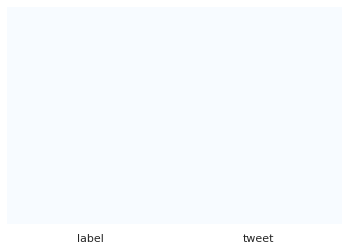

In [107]:
# The following Heat Map would display colored cells corresponding to NULL values in our dataset.

sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap="Blues")     
# Apparently, there are no null values in our dataset.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb6b36af2b0>]],
      dtype=object)

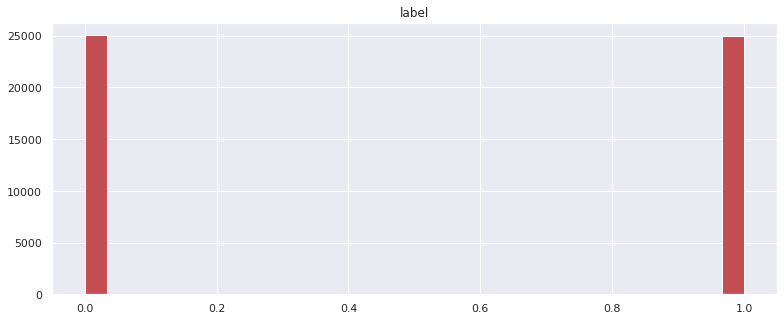

In [108]:
# Histogram

df.hist(bins=30, figsize=(13,5), color='r')

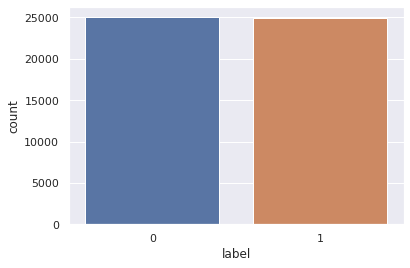

In [109]:
# Seaborn Countplot

sns.set(style="darkgrid")
ax = sns.countplot(x='label', data=df)
plt.show()

In [110]:
# Adding a column that keeps track of the number of words in a tweet...

df['length']= df['tweet'].apply(len)

In [111]:
df.head()

,label,tweet,length
876159,1,Gaucho grill is really outstandig btw. Excelle...,102
196418,0,My stomache is hurting. I went to bed at 5 ...,137
1352771,1,Recommended @kendallthiessen to @MrTweet 'I lo...,138
334954,0,I can't get to sleep &amp; I'm supposed to get...,67
219095,0,@Mkenn076 fer sure. Packing sucks. We just mo...,118


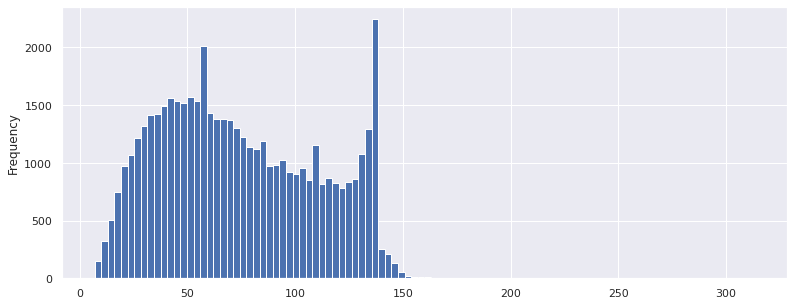

In [112]:
# Histogram for the length of tweets.

df['length'].plot(bins=100, figsize=(13,5), kind='hist')

In [113]:
df.describe()

,label,length
count,50000.000000,50000.000000
mean,0.499500,74.304620
std,0.500005,36.405295
min,0.000000,7.000000
25%,0.000000,44.000000
50%,0.000000,69.000000
75%,1.000000,104.000000
max,1.000000,313.000000


In [114]:
# Let's see the shortest tweet

df[df['length'] == 7]['tweet'].iloc[0]

'Off JB '

In [115]:
# Let's see the tweet with the average length

df[df['length'] == 74]['tweet'].iloc[0]

'check out: queen-of-randomness8.deviantart.com D its my DA account~ enjoy '

### Now we will explore Positive and Negative tweets in our dataset.

In [116]:
positive = df[df['label']==1]
positive

,label,tweet,length
876159,1,Gaucho grill is really outstandig btw. Excelle...,102
1352771,1,Recommended @kendallthiessen to @MrTweet 'I lo...,138
1455069,1,That was fun. B&amp;V...beatings and violation,47
834014,1,"@rimamelati hahaha! oh, yes. i think i will tr...",85
1137659,1,=]]]]]]]]]]]]]]]] crappy movie. great night,44
...,...,...,...
1536393,1,brainstorming ways to promote this upcoming to...,79
1594253,1,"@Nikki224 - it's like satc code. mr big, the ...",72
1482420,1,@mikebailey01 I just became one of you followe...,83
988648,1,"Listening to NPR, and a little tripped out to ...",121


In [117]:
negative = df[df['label']==0]
negative

,label,tweet,length
196418,0,My stomache is hurting. I went to bed at 5 ...,137
334954,0,I can't get to sleep &amp; I'm supposed to get...,67
219095,0,@Mkenn076 fer sure. Packing sucks. We just mo...,118
456350,0,Eating pancakes wacthing the rest of this game...,131
655212,0,I didn't buy anything no one wanted to come w...,73
...,...,...,...
276393,0,Is working a late one tonight won't b home ti...,58
638608,0,Donald Trump presenting Raw (wrestling)?!? Lma...,88
198737,0,Still with this diddy shit??? Its sickening a...,81
458119,0,@Monicayh nope.. had no time to go im afraid. ...,85


# **Plotting the Wordcloud for Positive and Negative Tweets**

In [118]:
sentences = df['tweet'].tolist()
sentences[:20]

["Gaucho grill is really outstandig btw. Excellent meat, excellent wine, bit pricy, but i'm on expenses ",
 "My stomache is hurting.    I went to bed at 5 and it's not even 8..I just want to sleep. I think I am slightly dehydrated..drinking water",
 "Recommended @kendallthiessen to @MrTweet 'I love you man!  A fun follow who shares an interest in healthcare tech...' http://cli.gs/aQ47UR",
 "I can't get to sleep &amp; I'm supposed to get up @ 6. This sucks. ",
 '@Mkenn076 fer sure.  Packing sucks. We just moved here in Feb. Before that we had just moved in Aug. Move, move, move.',
 'That was fun. B&amp;V...beatings and violation ',
 '@rimamelati hahaha! oh, yes. i think i will try and consider it  thanks for the info.',
 'Eating pancakes wacthing the rest of this game. I gotta go register for school tomorrow  I dont even have the energy. #summerschool',
 "I didn't buy anything  no one wanted to come with me so i stayed at home.",
 '=]]]]]]]]]]]]]]]] crappy movie. great night ',
 '@Verit

In [119]:
len(sentences)

50000

In [120]:
sentences_as_string = " ".join(sentences)

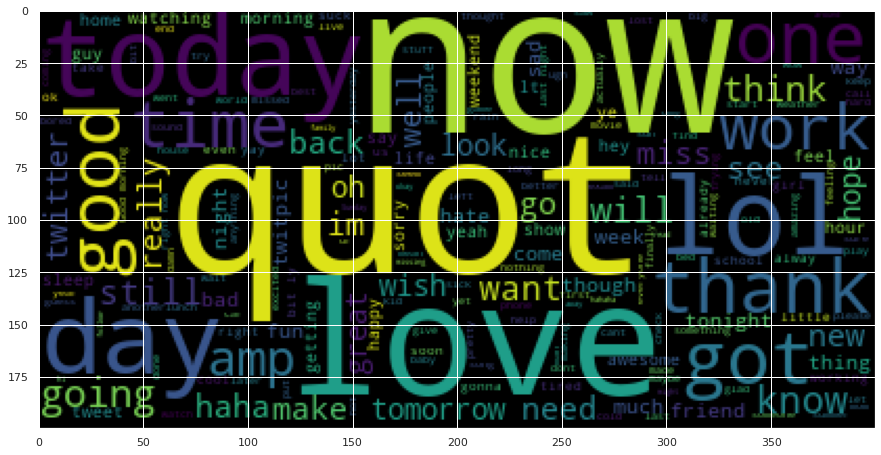

In [121]:
!pip install WordCloud
from wordcloud import WordCloud

plt.figure(figsize=(15,15))
plt.imshow(WordCloud().generate(sentences_as_string))

### Plotting Wordcloud of the "Positive" Dataframe

In [122]:
positive_sentences = positive['tweet'].tolist()
pos_sentences_as_string = " ".join(sentences)

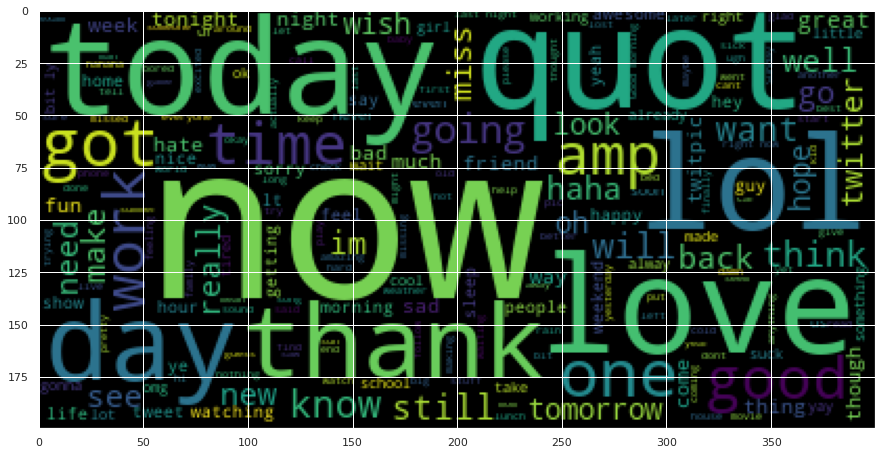

In [123]:
plt.figure(figsize=(15,15))
plt.imshow(WordCloud().generate(pos_sentences_as_string))

# The following WordCloud has been plotted using positive tweets only, so we will notice 
# mostly positive words in the WordCloud such as- 'good', 'thank', 'happy', 'well', 'love', etc.

### Plotting Wordcloud of the "Negative" Dataframe

In [124]:
negative_sentences = negative['tweet'].tolist()
neg_sentences_as_string = " ".join(sentences)

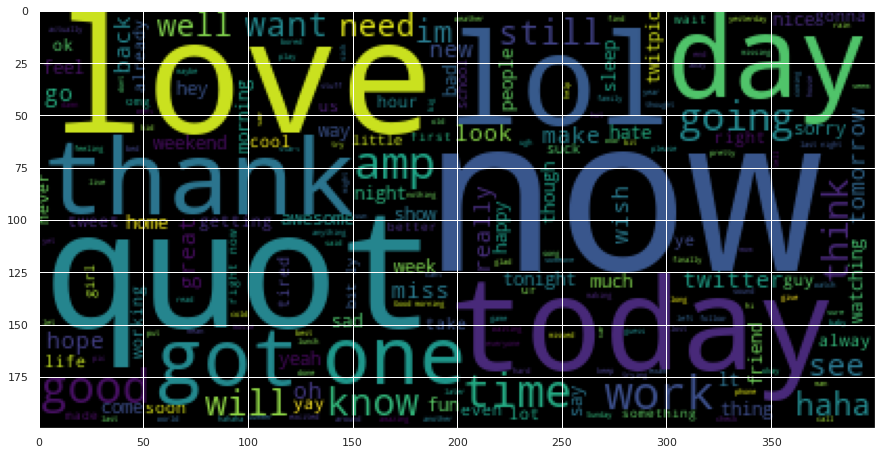

In [125]:
plt.figure(figsize=(15,15))
plt.imshow(WordCloud().generate(neg_sentences_as_string))

# The following WordCloud has been plotted using negative tweets only, so we will notice 
# mostly negative words in the WordCloud such as- 'sorry', 'suck', 'hate', 'sad', 'working', etc.

# **Data Cleaning (1) : Removing Punctuation**

In [126]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [127]:
Test_text = "Good Morning friends!!! I am Arshpreet from India.... ML is fun :)"

Here, we will use the function ***maketrans()*** to create an empty mapping table. The third argument of this function allows us to list all of the characters to remove during the translation process. We will include all the punctuation symbols using *string.punctuation*.

Python function ***translate()*** maps one set of characters to another.

In [128]:
words = Test_text.split()
table = str.maketrans('', '', string.punctuation)
stripped = [w.translate(table) for w in words]
print(stripped[:100])

['Good', 'Morning', 'friends', 'I', 'am', 'Arshpreet', 'from', 'India', 'ML', 'is', 'fun', '']


In [129]:
punc_remove_join_test = ' '.join(stripped)
punc_remove_join_test

'Good Morning friends I am Arshpreet from India ML is fun '

In [130]:
##### Alternate Method:- #####
# test_punc_removed = [char for char in Test_text if char not in string.punctuation]
# joined_test = ''.join(test_punc_removed)
# joined_test

# **Data Cleaning (2) : Removing Stopwords**

In [131]:
import nltk   #natural language toolkit
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [132]:
# Downloading stopwords Package

from nltk.corpus import stopwords
stopwords.words('english')

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [133]:
data_cleaned = [word for word in punc_remove_join_test.split() if word.lower() not in stopwords.words('english')]
data_cleaned

['Good', 'Morning', 'friends', 'Arshpreet', 'India', 'ML', 'fun']

# **Data Cleaning (3) : Performing Count Vectorization**

In [134]:
from sklearn.feature_extraction.text import CountVectorizer
sample_data = ['This is my computer.', 'This laptop is a computer.', 'This computer is my computer.']

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(sample_data)

In [135]:
print(vectorizer.get_feature_names())

['computer', 'is', 'laptop', 'my', 'this']


In [136]:
print(X.toarray())

[[1 1 0 1 1]
 [1 1 1 0 1]
 [2 1 0 1 1]]


# **Now we will create a single NLP Data Preprocessing Pipeline to remove punctuations, stopwords, and perform Count Vectorization**

In [137]:
def data_preprocess(tweet):

  # Removing Usernames
  tweet = re.sub('@[^\s]+','',tweet)
  
  # Removing Punctuation
  words = tweet.split()
  table = str.maketrans('', '', string.punctuation)
  stripped = [w.translate(table) for w in words]
  test_punc_removed = ' '.join(stripped)

  # Removing Stopwords
  test_punc_removed_clean = [word for word in test_punc_removed.split() if word.lower() not in stopwords.words('english')]

  return test_punc_removed_clean

In [138]:
# Let's test this function on our original dataset
#tweets_cleaned = df['tweet'][15].apply(data_preprocess)
#print(tweets_cleaned['tweet'][15])    # Cleaned-up Version
#print(tweets_cleaned['tweet'][687])

In [139]:
#print(df['tweet'][15])    # Original Version
#print(df['tweet'][687])

In [142]:
vectorizer = CountVectorizer(analyzer = data_preprocess, dtype='uint8')
tweets_vectorizer = vectorizer.fit_transform(df['tweet'])

In [143]:
print(vectorizer.get_feature_names())

['0', '00', '007', '0074', '01', '010', '02', '025', '02h00', '03', '032409', '04', '0400', '0409', '0430', '0433963407', '0448417513', '0530', '060', '0624', '0635', '06lbs', '07', '08', '08S26', '08lbs', '09', '090909', '0915', '091808', '092309', '093M3', '099', '0NE', '0NLY', '0f', '0fFicIaL', '0n', '0oops', '0r', '0s', '0simplyunperfect0', '1', '10', '100', '1000', '10000', '100000', '1000000', '1000s', '1000th', '1002am', '1005', '1008', '100F', '100i', '100k', '100pm', '100th', '100x', '101', '1010', '1011', '1012', '1013', '1014', '1015', '101580', '1016', '1019', '102', '102500', '102909', '102am', '103', '1030', '1030830dont', '1030am', '1030ish', '1030pm', '104', '104511', '1045pm', '105', '1050', '1051', '1057', '106', '1064', '1066', '1067', '106ampPark', '107', '1079', '108', '1080i', '109', '10AM', '10K', '10K4908', '10Kth', '10a', '10am', '10am1pm', '10b1', '10gb', '10ish', '10it', '10k', '10m', '10mila', '10min', '10mins', '10minutesbutoh', '10pm', '10th', '10x', '10ï¿

In [144]:
print(tweets_vectorizer.toarray())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [145]:
tweets_vectorizer.shape

(50000, 55151)

In [146]:
X = tweets_vectorizer
y = df['label']

# **Training a Naive-Bayes Classifier Model**

In [147]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [148]:
from sklearn.naive_bayes import MultinomialNB

NB_classifier = MultinomialNB()
NB_classifier.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

# **Analyzing Trained Model's Performance**

In [149]:
from sklearn.metrics import classification_report, confusion_matrix

### Confusion Matrix

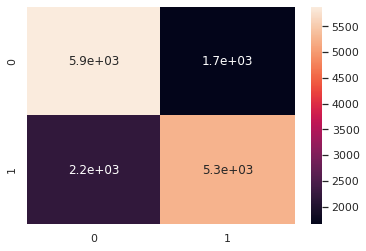

In [150]:
y_test_predict = NB_classifier.predict(X_test)
cm = confusion_matrix(y_test, y_test_predict)
sns.heatmap(cm, annot=True)

### Classification Report

In [151]:
print(classification_report(y_test, y_test_predict))

              precision    recall  f1-score   support

           0       0.73      0.78      0.75      7533
           1       0.76      0.70      0.73      7467

    accuracy                           0.74     15000
   macro avg       0.74      0.74      0.74     15000
weighted avg       0.74      0.74      0.74     15000



In [152]:
print(NB_classifier.predict(X_test[:3]))

[1 1 1]


## We got an accuracy of **74%** on our Naive-Bayes Model!!!